In [3]:
!pwd

/home/jovana/code/y01a-BG/NeuroPredict/notebooks


In [6]:
import sys
# Add the directory containing the EEG package to sys.path
sys.path.append('/home/jovana/code/y01a-BG/NeuroPredict/EEG')
import os
import pandas as pd
import numpy as np
 
from preprocessor_01 import preprocess_data
from X_y_test_train_rand_02 import test_train_split_save
from encoding_03 import encoder_LSTM
from modeling_04 import initialize_lstm_model, compile_lstm_model
from training_05 import train_lstm_model
from evaluating_06 import evaluate_lstm
#from predictor_07 import pred_lstm


2025-03-24 11:20:08.561203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-24 11:20:09.076398: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 11:20:09.111103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-24 11:20:09.111172: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [113]:
input_path = "/home/jovana/code/y01a-BG/NeuroPredict/raw_data"
file_name = "Epileptic Seizure Recognition.csv"
file_path = os.path.join(input_path, file_name)

output_path = "/home/jovana/code/y01a-BG/NeuroPredict/processed_data"
data_file = "data.csv"
data_path = os.path.join(output_path, data_file)
data = pd.read_csv(file_path)

X_pred_file_name = "random_test_samples.csv"
X_pred_file_path = os.path.join(output_path, X_pred_file_name)

X_pred = pd.read_csv(X_pred_file_path)


In [114]:
#######preprocessor_01
data = preprocess_data(data, data_path)
X = data.drop(columns = 'y')
y = data.y
print(f"✅ Raw data cleaned and separated (X,y)")

✅ Data preprocessed and saved to: /home/jovana/code/y01a-BG/NeuroPredict/processed_data/data.csv
✅ Raw data cleaned and separated (X,y)


In [115]:
####### test_and_train_split_02
X_train, X_test, y_train, y_test, random_test_samples = test_train_split_save(X,y,output_path)

✅ Data split into train/test/random-pred and saved as .csv


In [116]:
#### encoding_03 for LSTM
X_train,y_train = encoder_LSTM(X_train,y_train)
X_test, y_test = encoder_LSTM(X_test, y_test)

✅ Train data encoded for LSTM, with X_train shape : (5520, 178, 1) and y_train shape; (5520, 3)
✅ Train data encoded for LSTM, with X_train shape : (1380, 178, 1) and y_train shape; (1380, 3)


In [13]:
### modeling_04 for LSTM
input_shape = (178,1)
model = initialize_lstm_model(input_shape)
modelLSTM = compile_lstm_model(model)

2025-03-24 11:22:38.154016: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-24 11:22:38.154549: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-24 11:22:38.154621: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-03-24 11:22:38.154654: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-03-24 11:22:38.154699: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

✅ LSTM Model initialized
✅ LSTM Model compiled


In [14]:
##### training_05
model,history = train_lstm_model(model,
        X_train,y_train,
        batch_size=128,
        patience=1,
        validation_data=None, # overrides validation_split
        validation_split=0.2
        )


Training model...
Epoch 1/150
35/35 [==============================] - 29s 604ms/step - loss: 0.7835 - accuracy: 0.5840 - val_loss: 0.7948 - val_accuracy: 0.5960
Epoch 2/150
35/35 [==============================] - 24s 704ms/step - loss: 0.6769 - accuracy: 0.6098 - val_loss: 0.7149 - val_accuracy: 0.6069
Epoch 3/150
35/35 [==============================] - 28s 799ms/step - loss: 0.6320 - accuracy: 0.6332 - val_loss: 0.6466 - val_accuracy: 0.6259
Epoch 4/150
35/35 [==============================] - 29s 820ms/step - loss: 0.6084 - accuracy: 0.6454 - val_loss: 0.6110 - val_accuracy: 0.6295
Epoch 5/150
35/35 [==============================] - 29s 828ms/step - loss: 0.5726 - accuracy: 0.6583 - val_loss: 0.6003 - val_accuracy: 0.6286
Epoch 6/150
35/35 [==============================] - 29s 829ms/step - loss: 0.5635 - accuracy: 0.6578 - val_loss: 0.6659 - val_accuracy: 0.6404
Epoch 6: early stopping
✅ LSTM Model trained on 5520 rows with min val MAE: 0.6


In [19]:
import matplotlib.pyplot as plt
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

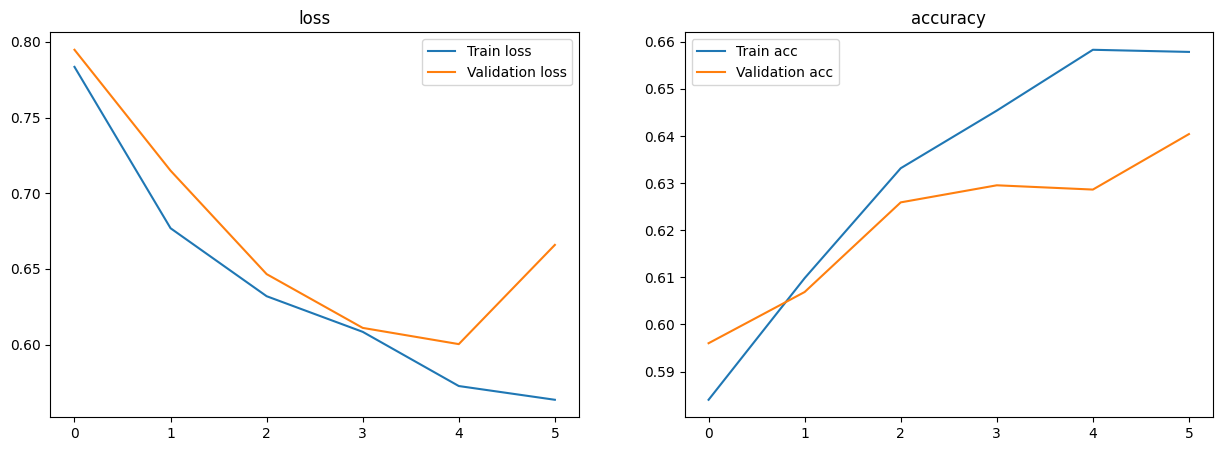

In [20]:
plot_history(history)

In [ ]:
# Save LSTM  trained model
#model.save("models/LSTMmodel.h5")

In [24]:
# evaluating_06
# Assuming model.predict(X_test) gives probabilities for each class

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels (index of the max probability)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate accuracy score
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='macro')  # 'macro' averages metrics across all classes
recall = recall_score(y_test_labels, y_pred_labels, average='macro')
f1 = f1_score(y_test_labels, y_pred_labels, average='macro')

# Display results as a table
results = {
        'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)'],
        'Score': [accuracy, precision, recall, f1]
    }

# Create DataFrame for easy display
results_df = pd.DataFrame(results)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
print("✅ \nConfusion Matrix:")
print(conf_matrix)
# Create classification report (including precision, recall, f1-score per class)
class_report = classification_report(y_test_labels, y_pred_labels, target_names=['Class 0', 'Class 1', 'Class 2'])
print("✅ \nClassification Report:")
print(class_report)

44/44 [==============================] - 4s 82ms/step
✅ 
Confusion Matrix:
[[408  31  10]
 [  9 441   7]
 [  3 462   9]]
✅ 
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.91      0.94       449
     Class 1       0.47      0.96      0.63       457
     Class 2       0.35      0.02      0.04       474

    accuracy                           0.62      1380
   macro avg       0.60      0.63      0.54      1380
weighted avg       0.59      0.62      0.53      1380



In [31]:
#predicting_07
X_processed = encoder_LSTM(X_pred)
y_pred_probs = model.predict(X_test)

✅ y_train is not provided, only X_train will be encoded.
44/44 [==============================] - 4s 85ms/step


In [32]:
y_pred_probs

array([[9.7793067e-01, 1.8687554e-02, 3.3818318e-03],
       [9.7926622e-03, 5.9865969e-01, 3.9154765e-01],
       [9.9492568e-01, 4.5276303e-03, 5.4664211e-04],
       ...,
       [1.8956062e-01, 3.9943838e-01, 4.1100103e-01],
       [9.7861663e-03, 5.9154499e-01, 3.9866886e-01],
       [9.7387683e-01, 1.5064349e-02, 1.1058716e-02]], dtype=float32)

In [145]:
# Part of the code that modifies the thresholds

predicted_classes = []
thresholds = [0.5, 0.4, 0.4]

# Iterate over the probabilities and apply the thresholds
for prob in y_pred_probs:
    if prob[0] > thresholds[0]:  # Class 1 threshold
        predicted_classes.append(0)
    elif prob[1] > thresholds[1]:  # Class 2 threshold
        predicted_classes.append(1)
    elif prob[2] > thresholds[2]:  # Class 3 threshold
        predicted_classes.append(2)
    else:
        # If none of the classes exceed the threshold, you can choose to
        # either assign a default class or skip this example.
        predicted_classes.append(1)  # or choose another class, e.g., 0

print(predicted_classes)

[0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 2, 0, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 2, 0, 1, 2, 1, 2, 1, 1, 1, 0, 0, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 2, 1, 1, 0, 2, 0, 0, 1, 0, 2, 0, 2, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 1, 0, 1, 2, 1, 1, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 2, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 2, 0, 0, 1, 1, 1, 

In [147]:
type(predicted_classes)
predicted_classes_array = np.array(predicted_classes)

In [69]:
predicted_classes_array

array([0, 1, 0, ..., 2, 1, 0])

In [70]:
y_test_labels

array([0, 1, 0, ..., 0, 2, 0])

In [148]:
# Convert probabilities to class labels (index of the max probability)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

#Calculate accuracy score
accuracy = accuracy_score(y_test_labels,predicted_classes)
precision = precision_score(y_test_labels,predicted_classes, average='macro')  # 'macro' averages metrics across all classes
recall = recall_score(y_test_labels,predicted_classes, average='macro')
f1 = f1_score(y_test_labels,predicted_classes, average='macro')

# Display results as a table
results = {
        'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)'],
        'Score': [accuracy, precision, recall, f1]
    }

# Create DataFrame for easy display
results_df = pd.DataFrame(results)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels,predicted_classes)
print("✅ \nConfusion Matrix:")
print(conf_matrix)
# Create classification report (including precision, recall, f1-score per class)
class_report = classification_report(y_test_labels, predicted_classes, target_names=['Class 0', 'Class 1', 'Class 2'])
print("✅ \nClassification Report:")
print(class_report)

✅ 
Confusion Matrix:
[[431  17   1]
 [ 10 392  55]
 [  4 387  83]]
✅ 
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.96      0.96       449
     Class 1       0.49      0.86      0.63       457
     Class 2       0.60      0.18      0.27       474

    accuracy                           0.66      1380
   macro avg       0.69      0.66      0.62      1380
weighted avg       0.68      0.66      0.61      1380



In [112]:
X_train.shape

(5520, 178, 1, 1)

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_shape= (178,1)
model1 = Sequential()

# First Bidirectional LSTM layer with L2 regularization
model1.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True, 
                                  kernel_regularizer='l2'), input_shape=input_shape))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

# Second Bidirectional LSTM layer with L2 regularization
model1.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True, 
                                  kernel_regularizer='l2')))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

# Third LSTM layer with fewer units and L2 regularization
model1.add(LSTM(64, activation='tanh', kernel_regularizer='l2'))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

# Dense layer with ReLU activation
model1.add(Dense(64, activation='relu'))

# Output layer with softmax activation for multi-class classification
model1.add(Dense(3, activation='softmax'))

# Compile the model with the Adam optimizer and sparse categorical cross-entropy loss
model1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print("✅ Improved LSTM Model1 initialized")



✅ Improved LSTM Model1 initialized


In [144]:
##### training_05
import tensorflow as tf
from keras import callbacks


es = EarlyStopping(
    monitor="val_loss",
    patience=1,
    restore_best_weights=True,
    verbose=-1
)

# Train the model
history1 = model1.fit(
    X_train, y_train,
    batch_size=128,
    validation_split=0.2,  # This will automatically split 20% of the data for validation
    epochs=50,  # Define the number of epochs, or set it according to your needs
    callbacks=[es]  # Add early stopping callback
)

Epoch 1/50
35/35 [==============================] - 28s 795ms/step - loss: 0.6504 - accuracy: 0.6424 - val_loss: 0.6696 - val_accuracy: 0.6486
Epoch 2/50
35/35 [==============================] - 44s 1s/step - loss: 0.6445 - accuracy: 0.6653 - val_loss: 0.6427 - val_accuracy: 0.6812
Epoch 3/50
35/35 [==============================] - 48s 1s/step - loss: 0.6197 - accuracy: 0.6533 - val_loss: 0.6154 - val_accuracy: 0.6793
Epoch 4/50
35/35 [==============================] - 40s 1s/step - loss: 0.6036 - accuracy: 0.6608 - val_loss: 0.6073 - val_accuracy: 0.6793
Epoch 5/50
35/35 [==============================] - 34s 989ms/step - loss: 0.6026 - accuracy: 0.6635 - val_loss: 0.8775 - val_accuracy: 0.5788


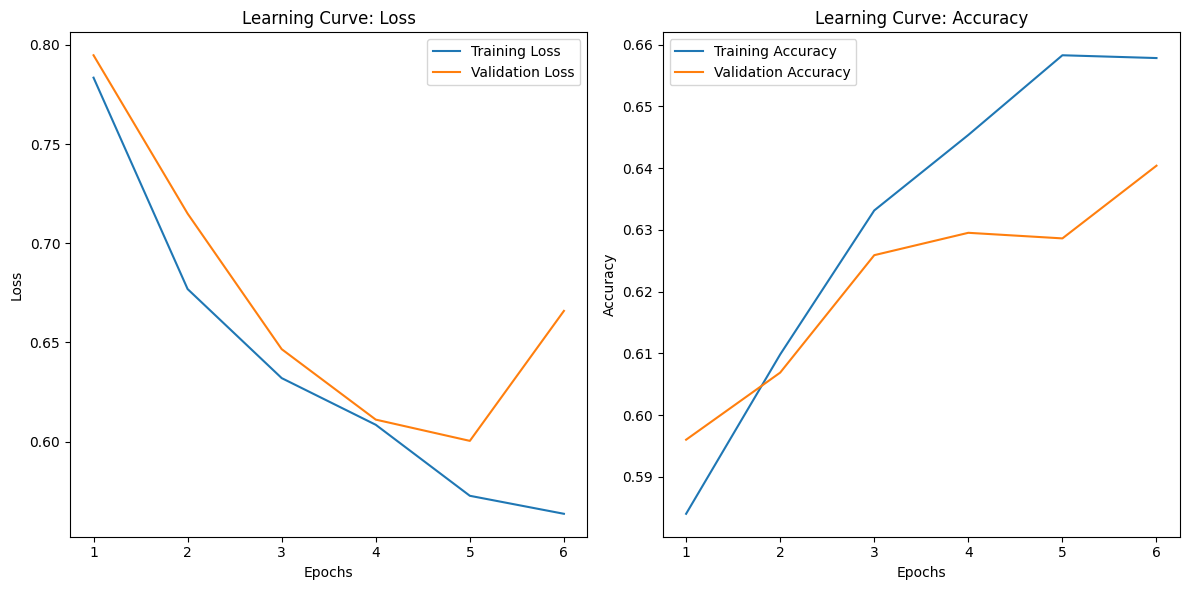

In [141]:
#Learning curve
import matplotlib.pyplot as plt

# Extract training and validation loss/accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting the learning curve for loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Learning Curve: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Learning Curve: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [142]:
# evaluating_06
# Assuming model.predict(X_test) gives probabilities for each class

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
y_pred_probs = model1.predict(X_test)

# Convert probabilities to class labels (index of the max probability)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate accuracy score
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='macro')  # 'macro' averages metrics across all classes
recall = recall_score(y_test_labels, y_pred_labels, average='macro')
f1 = f1_score(y_test_labels, y_pred_labels, average='macro')

# Display results as a table
results = {
        'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)'],
        'Score': [accuracy, precision, recall, f1]
    }

# Create DataFrame for easy display
results_df = pd.DataFrame(results)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
print("✅ \nConfusion Matrix:")
print(conf_matrix)
# Create classification report (including precision, recall, f1-score per class)
class_report = classification_report(y_test_labels, y_pred_labels, target_names=['Class 0', 'Class 1', 'Class 2'])
print("✅ \nClassification Report:")
print(class_report)

44/44 [==============================] - 6s 131ms/step
✅ 
Confusion Matrix:
[[437   9   3]
 [ 15  69 373]
 [  4  47 423]]
✅ 
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.97      0.97       449
     Class 1       0.55      0.15      0.24       457
     Class 2       0.53      0.89      0.66       474

    accuracy                           0.67      1380
   macro avg       0.68      0.67      0.62      1380
weighted avg       0.68      0.67      0.62      1380



In [143]:
y_pred_probs

array([[9.8964339e-01, 9.4287638e-03, 9.2781318e-04],
       [4.0138038e-03, 4.1222569e-01, 5.8376056e-01],
       [9.9238610e-01, 7.1497052e-03, 4.6420025e-04],
       ...,
       [7.1871120e-01, 2.1436407e-01, 6.6924758e-02],
       [1.8261340e-02, 4.7438046e-01, 5.0735813e-01],
       [9.8411721e-01, 1.0570957e-02, 5.3118309e-03]], dtype=float32)

In [ ]:
# Part of the code that modifies the thresholds

predicted_classes = []
thresholds = [0.5, 0.7, 0.4]

# Iterate over the probabilities and apply the thresholds
for prob in y_pred_probs:
    if prob[0] > thresholds[0]:  # Class 1 threshold
        predicted_classes.append(0)
    elif prob[1] > thresholds[1]:  # Class 2 threshold
        predicted_classes.append(1)
    elif prob[2] > thresholds[2]:  # Class 3 threshold
        predicted_classes.append(2)
    else:
        # If none of the classes exceed the threshold, you can choose to
        # either assign a default class or skip this example.
        predicted_classes.append(1)  # or choose another class, e.g., 0

print(predicted_classes)